- 코드 참고: 도서 <실전! 딥러닝(위키북스)>

### - X: 이미지의 밝기 정보(L) --> Y: 이미지의 컬러 정보(AB)
### - RGB 이미지를 LAB로 변환하여 밝기(L)을 X, 컬러(AB)를 Y로 분리
### - 최종적으로 예측데이터 AB에 입력데이터 L을 결합하여 LAB 이미지를 만들고 이를 RGB로 변환하여 채색이미지 출력

- 모듈 임포트 및 구글드라이브 마운트

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os, glob, math, random, cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.python.keras.callbacks import ModelCheckpoint

from IPython.display import display_png
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### @@@데이터 폴더로 이동하기@@@

In [ ]:
# '.../세미(2) 프로젝트/2.데이터'로 이동하기
%cd /content/drive/MyDrive/04 멀캠/세미(2) 프로젝트/2.데이터

### @@@포켓몬 설정하기@@@

In [20]:
print('내 포켓볼 --> 0.이상해씨 1.잠만보 2.이브이 3.파이리 4.꼬부기 5.피카츄 6.지우 7.이슬이')
idx = int(input('너로 정했다~!(번호 입력) --> '))

내 포켓볼 --> 0.이상해씨 1.잠만보 2.이브이 3.파이리 4.꼬부기 5.피카츄 6.지우 7.이슬이
너로 정했다~!(번호 입력) --> 1


### @@@전역 변수 설정하기@@@

In [21]:
## 전역 변수

categories = ['isang', 'jammanbo', 'evee', 'pie', 'squirtle', 'pikachu', 'jiwoo', 'leeseul']
img_size = 128
batch_size = 30
epochs = 3000
monitor = 'val_loss'

- 데이터 불러오고 나누기
 - 전체 데이터: 500개
 - Train 데이터: 430개
 - Valid 데이터: 50개
 - Test 데이터: 20개

In [22]:
# 포켓몬 이미지 500장을 Train/Valid/Test 데이터셋으로 분리

# 이미지 경로 얻기
data_path = categories[idx]
data_lists = glob.glob(os.path.join(data_path, '*.jpg'))

# 데이터 개수 설정
val_n_sample = math.floor(len(data_lists)*0.1)                    # 50개
test_n_sample = math.floor(len(data_lists)*0.04)                  # 20개
train_n_sample = len(data_lists) - val_n_sample - test_n_sample   # 430개

# data_list(이미지 경로 모음) 생성
val_lists = data_lists[:val_n_sample]
test_lists = data_lists[val_n_sample:val_n_sample + test_n_sample]
train_lists = data_lists[val_n_sample + test_n_sample:train_n_sample + val_n_sample + test_n_sample]

print(f'Train data: {len(train_lists)}개   Valid data: {len(val_lists)}개    Test data:{len(test_lists)}개')

Train data: 430개   Valid data: 50개    Test data:20개


In [23]:
## 함수

# RGB -> LAB 이미지로 변환
def rgb2lab(rgb):
    assert rgb.dtype == 'uint8'
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2Lab)

# LAB -> RGB 이미지로 변환
def lab2rgb(lab):
    assert lab.dtype == 'uint8'
    return cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)

# data_list 내 RGB 이미지를 LAB array로 반환
def get_lab_from_data_list(data_list):
    x_lab = []
    for f in data_list:
        rgb = img_to_array(load_img(f, target_size=(img_size, img_size))).astype(np.uint8)    # RGB 이미지를 128*128 사이즈로 불러와 array로 변환
        lab = rgb2lab(rgb)    # RGB array -> LAB array로 변환
        x_lab.append(lab)     # LAB array를 리스트에 저장
    return np.stack(x_lab)    # 리스트를 array로 변환

In [24]:
# 위 셀의 3가지 함수를 활용한 최종 함수
# data_list 내 RGB 이미지를 generator(L array, AB array)로 반환
# generator 1개 당 이미지 batch_size개
def generator_with_preprocessing(data_list, batch_size, shuffle=False):
    while True:
        if shuffle:
            np.random.shuffle(data_list)                      # 데이터 순서 섞기
        for i in range(0, len(data_list), batch_size):
            batch_list = data_list[i:i + batch_size]          # batch_size만큼 이미지 가져오기
            batch_lab = get_lab_from_data_list(batch_list)    # 이미지 LAB array로 변환
            batch_l = batch_lab[:, :, :, 0:1]                 # L 값만 추출 -> (batch_size, 128, 128, 1)
            batch_ab = batch_lab[:, :, :, 1:]                 # AB 값만 추출 -> (batch_size, 128, 128, 2)
            yield (batch_l, batch_ab)

- 데이터 generator 생성

In [25]:
train_gen = generator_with_preprocessing(train_lists, batch_size, shuffle=True)    # 학습용 데이터는 셔플
val_gen = generator_with_preprocessing(val_lists, batch_size)
test_gen = generator_with_preprocessing(test_lists, batch_size)

train_steps = math.ceil(len(train_lists)/batch_size)
val_steps = math.ceil(len(val_lists)/batch_size)
test_steps = math.ceil(len(test_lists)/batch_size)

- 모델 생성 및 설정
  - MaxPooling 대신 Stride(2, 2) 적용 -> 축소 처리와 합성곱 처리를 한 층에서 실행
  - Conv2DTranspose(입력 텐서를 확대) -> 확대 처리와 합성곱 처리를 한 층에서 실행
  - 중간층의 크기가 너무 작으면 모델 전체의 표현력이 떨어지므로 Encoder에서 채널의 수를 2배로 늘려서 모델 전체의 표현력을 높이는 것이 일반적



In [26]:
model = Sequential()

# Encoder -> Stride(2, 2)
model.add(Conv2D(32, (3, 3), (1, 1), activation='relu', padding='same', input_shape=(img_size, img_size, 1)))    # 입력 데이터 = L(128, 128, 1)
model.add(Conv2D(64, (3, 3), (2, 2), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), (2, 2), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), (2, 2), activation='relu', padding='same'))

# Decoder -> Conv2DTranspose
model.add(Conv2DTranspose(128, (3, 3), (2, 2), activation='relu', padding='same'))
model.add(Conv2DTranspose(64, (3, 3), (2, 2), activation='relu', padding='same'))
model.add(Conv2DTranspose(32, (3, 3), (2, 2), activation='relu', padding='same'))
model.add(Conv2D(2, (1, 1), (1, 1), activation='relu', padding='same'))    # 출력 데이터 = AB(128, 128, 2)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 32, 32, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 64, 64, 64)       73792     
 ranspose)                                            

- 베스트 모델 저장

In [27]:
best_model_path = data_path + '_coloring_best_epochs' + str(epochs) + '_' + monitor + '.h5'
mc = ModelCheckpoint(best_model_path, monitor=monitor, save_best_only=True, verbose=0)
callbacks = [mc]

- 모델 학습

In [28]:
hist = model.fit_generator(generator=train_gen, steps_per_epoch=train_steps, epochs=epochs,
                           validation_data=val_gen, validation_steps=val_steps, callbacks=callbacks)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
15/15 [==============================] - 2s 125ms/step - loss: 104.3044 - accuracy: 0.6667 - val_loss: 221.6892 - val_accuracy: 0.6194
Epoch 502/3000
15/15 [==============================] - 2s 121ms/step - loss: 110.6790 - accuracy: 0.6727 - val_loss: 239.4100 - val_accuracy: 0.5873
Epoch 503/3000
15/15 [==============================] - 2s 122ms/step - loss: 116.3195 - accuracy: 0.6677 - val_loss: 226.3399 - val_accuracy: 0.5841
Epoch 504/3000
15/15 [==============================] - 2s 122ms/step - loss: 113.5860 - accuracy: 0.6690 - val_loss: 267.5540 - val_accuracy: 0.5901
Epoch 505/3000
15/15 [==============================] - 2s 124ms/step - loss: 110.9798 - accuracy: 0.6689 - val_loss: 226.2460 - val_accuracy: 0.6095
Epoch 506/3000
15/15 [==============================] - 2s 124ms/step - loss: 105.1081 - accuracy: 0.6635 - val_loss: 232.1822 - val_accuracy: 0.5863
Epoch 507/3000
15/15 [==============================] - 2s 124ms/step - loss: 1

- 학습과정 시각화

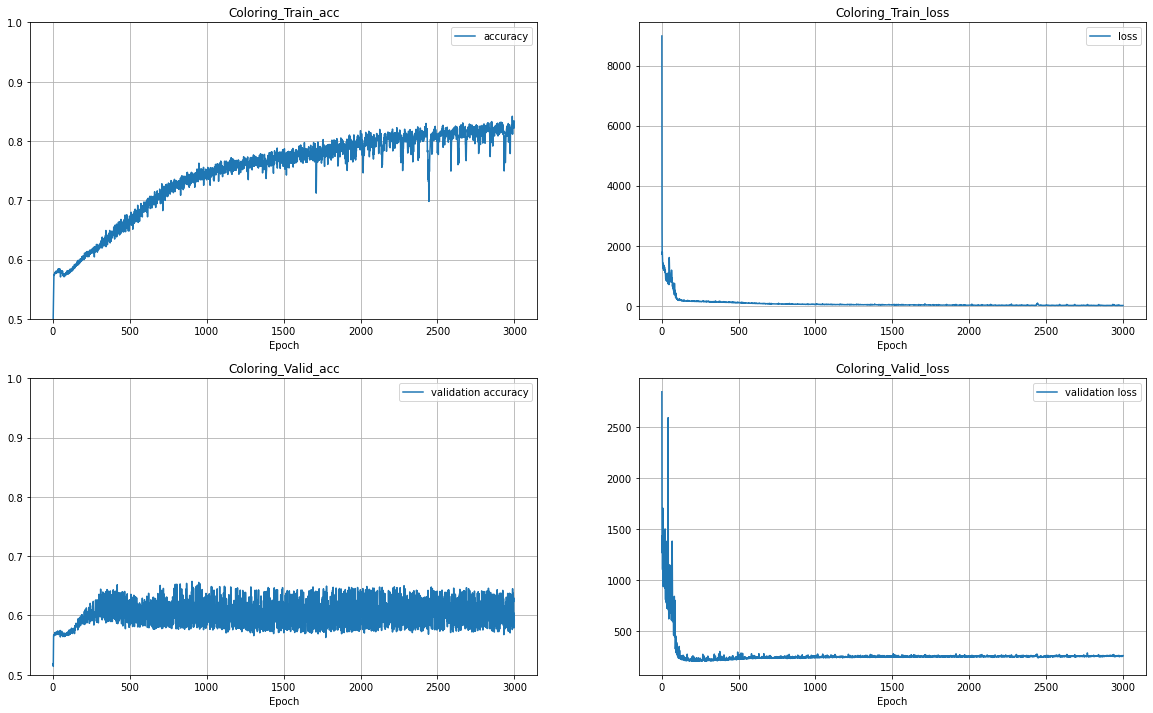

In [29]:
y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
y_vacc = hist.history['val_accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
plt.plot(xs, y_acc, label='accuracy')
plt.legend(), plt.grid(), plt.xlabel('Epoch'), plt.ylim(0.5, 1.)
plt.title('Coloring_Train_acc')

plt.subplot(2, 2, 2)
plt.plot(xs, y_loss, label='loss')
plt.legend(), plt.grid(), plt.xlabel('Epoch')
plt.title('Coloring_Train_loss')

plt.subplot(2, 2, 3)
plt.plot(xs, y_vacc, label='validation accuracy')
plt.legend(), plt.grid(), plt.xlabel('Epoch'), plt.ylim(0.5, 1.)
plt.title('Coloring_Valid_acc')

plt.subplot(2, 2, 4)
plt.plot(xs, y_vloss, label='validation loss')
plt.legend(), plt.grid(), plt.xlabel('Epoch')
plt.title('Coloring_Valid_loss')

plt.show();

- 모델 예측

In [30]:
# 베스트 모델 불러오기
best_model = load_model(best_model_path)
preds = best_model.predict_generator(test_gen, steps=test_steps)    # 예측 AB

- 채색 해보기
  - 예측 AB에 입력 L을 결합

In [31]:
# 입력 데이터 L 추출
x_test = []

for i, (l, _) in enumerate(test_gen):
    x_test.append(l)
    if i == (test_steps - 1):
        break
        
x_test = np.vstack(x_test)

In [32]:
# 입력 L과 예측 AB를 결합하여 LAB array 생성 -> RGB로 변환
test_preds_lab = np.concatenate((x_test, preds), 3).astype(np.uint8)

test_preds_rgb = []
for i in range(test_preds_lab.shape[0]):
    preds_rgb = lab2rgb(test_preds_lab[i, :, :, :])    # LAB -> RGB
    test_preds_rgb.append(preds_rgb)                   # RGB array를 리스트에 저장
test_preds_rgb = np.stack(test_preds_rgb)              # 리스트를 array로 변환

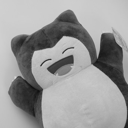

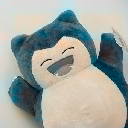

-------------------------


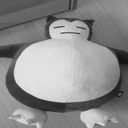

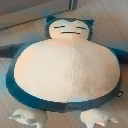

-------------------------


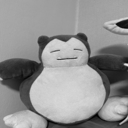

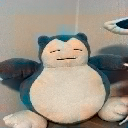

-------------------------


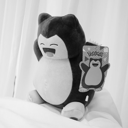

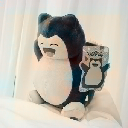

-------------------------


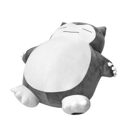

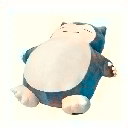

-------------------------


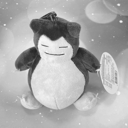

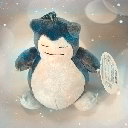

-------------------------


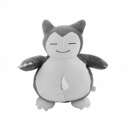

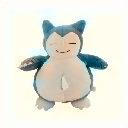

-------------------------


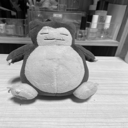

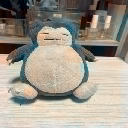

-------------------------


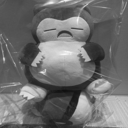

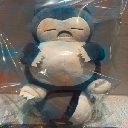

-------------------------


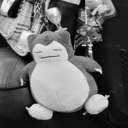

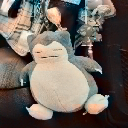

-------------------------


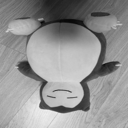

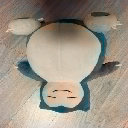

-------------------------


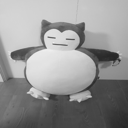

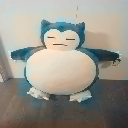

-------------------------


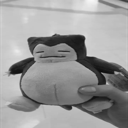

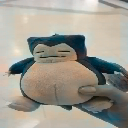

-------------------------


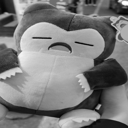

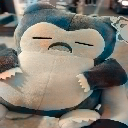

-------------------------


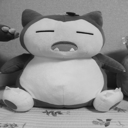

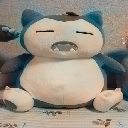

-------------------------


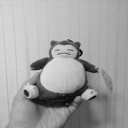

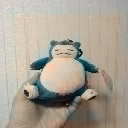

-------------------------


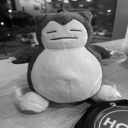

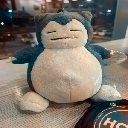

-------------------------


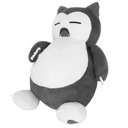

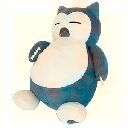

-------------------------


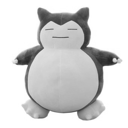

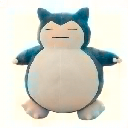

-------------------------


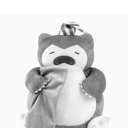

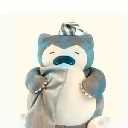

-------------------------


In [33]:
# 원본 흑백 이미지 & 채색 결과 함께 출력
for i in range(test_preds_rgb.shape[0]):
    img = Image.open(test_lists[i]).resize((img_size, img_size))
    gray_img = img.convert('L')
    display_png(gray_img)
    display_png(array_to_img(test_preds_rgb[i]))
    print('-'*25)